# Load model

In [1]:
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from birdclassification.training.dataset import Recordings30
from birdclassification.training.cnn_training_torch.CNN_model import CNNNetwork
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [2]:
PATH = 'saved_models/cnn_1.pt'
cnn = CNNNetwork()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [3]:
cnn.eval()

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=10880, out_features=30, bias=True)
)

# Prepare dataset

In [4]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 123
#RECORDINGS_DIR = '/mnt/d/recordings_30/'
RECORDINGS_DIR =  '/media/jacek/E753-A120/recordings_30/'
NOISES_DIR = '/path/to/noise/dataset'
SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 5
NUM_WORKERS = 8

/home/jacek/PycharmProjects/Bird-classification-model/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
df = filter_recordings_30("../../../data/xeno_canto_recordings.csv", "../../../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE, device = DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate = 32000, device = DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR,sample_rate = 32000,device = DEVICE)

train_dl  = DataLoader(train_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
val_dl  = DataLoader(val_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
test_dl  = DataLoader(test_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)

/home/jacek/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:72: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


## Show spectrograms

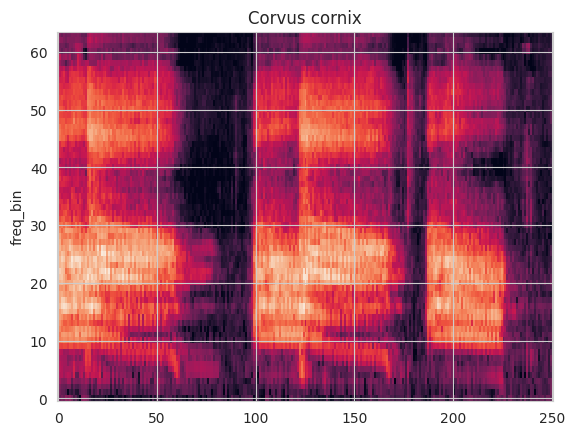

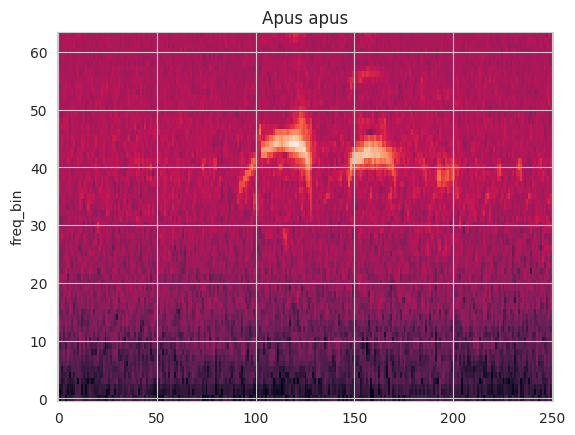

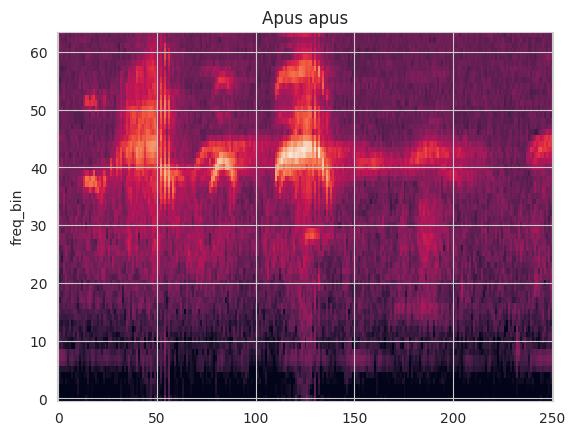

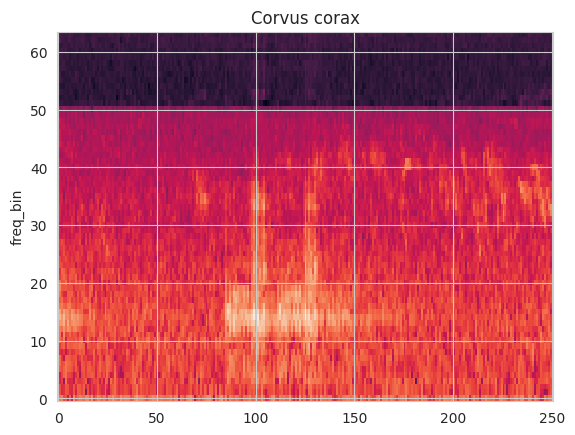

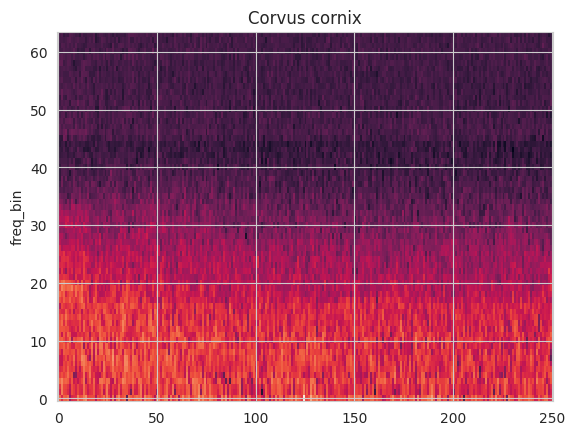

In [6]:
from birdclassification.visualization.plots import plot_torch_spectrogram

number_of_rec = 5
for i in range(number_of_rec):
    spectrogram, label = train_ds[i]
    plot_torch_spectrogram(spectrogram, title=train_ds.get_mapping()[label])

## Predict bird demo

Prediction:  Turdus viscivorus


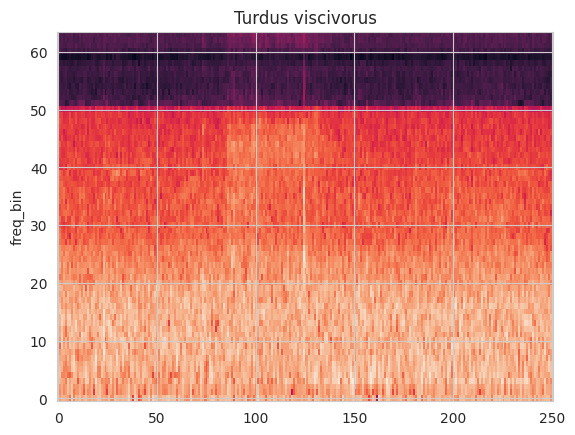

In [25]:
length_in_seconds = 3
sr = 32000
index = 27
map = train_ds.get_mapping()

cnn.eval()
with torch.no_grad():
    spectrogram, label = train_ds[index]
    plot_torch_spectrogram(spectrogram, title=map[label])
    spectrogram = torch.tensor(spectrogram)
    spectrogram = spectrogram.reshape([1, 1, 64, 251])
    validation_output = cnn(spectrogram)
    predictions = torch.max(validation_output, dim=1)[1].data.squeeze()
    
print("Prediction: ", train_ds.get_mapping()[predictions.item()])

# Validation

In [26]:
from birdclassification.training.validation_metrics import calculate_metric
from sklearn.metrics import f1_score, precision_score
import numpy as np

### F1 score (macro averaged)

In [9]:
f1_score = calculate_metric(cnn, val_dl, device=DEVICE, metric=lambda x, y: f1_score(x, y, average='macro'))
f1_score

0.6289532076871388

### Precision (macro averaged)

In [8]:
precision = calculate_metric(cnn, val_dl, device=DEVICE, metric=lambda x, y: precision_score(x, y, average='macro'))
precision

0.6966725769979618

### Classification report

In [34]:
names = list(train_ds.get_mapping().values())

In [ ]:
classification = calculate_metric(cnn, val_dl, device=DEVICE, metric=lambda x, y: classification_report(x, y, target_names=names))

In [16]:
print(0, classification)

0               precision    recall  f1-score   support

         0.0       0.73      0.87      0.80       265
         1.0       0.80      0.63      0.70       108
         2.0       0.85      0.73      0.79        71
         3.0       0.73      0.61      0.66       127
         4.0       0.59      0.67      0.63        94
         5.0       0.56      0.76      0.64       206
         6.0       0.64      0.50      0.56        14
         7.0       0.77      0.45      0.57        22
         8.0       0.55      0.88      0.68       207
         9.0       0.72      0.78      0.75       121
        10.0       0.62      0.69      0.65        70
        11.0       0.66      0.86      0.75       195
        12.0       0.45      0.27      0.34        52
        13.0       0.86      0.62      0.72       246
        14.0       0.57      0.59      0.58       188
        15.0       0.92      0.68      0.78        95
        16.0       0.75      0.56      0.64       166
        17.0       0.75  

In [28]:
c_matrix = calculate_metric(cnn, val_dl, device=DEVICE, metric=confusion_matrix)

Text(470.72222222222223, 0.5, 'Prediction')

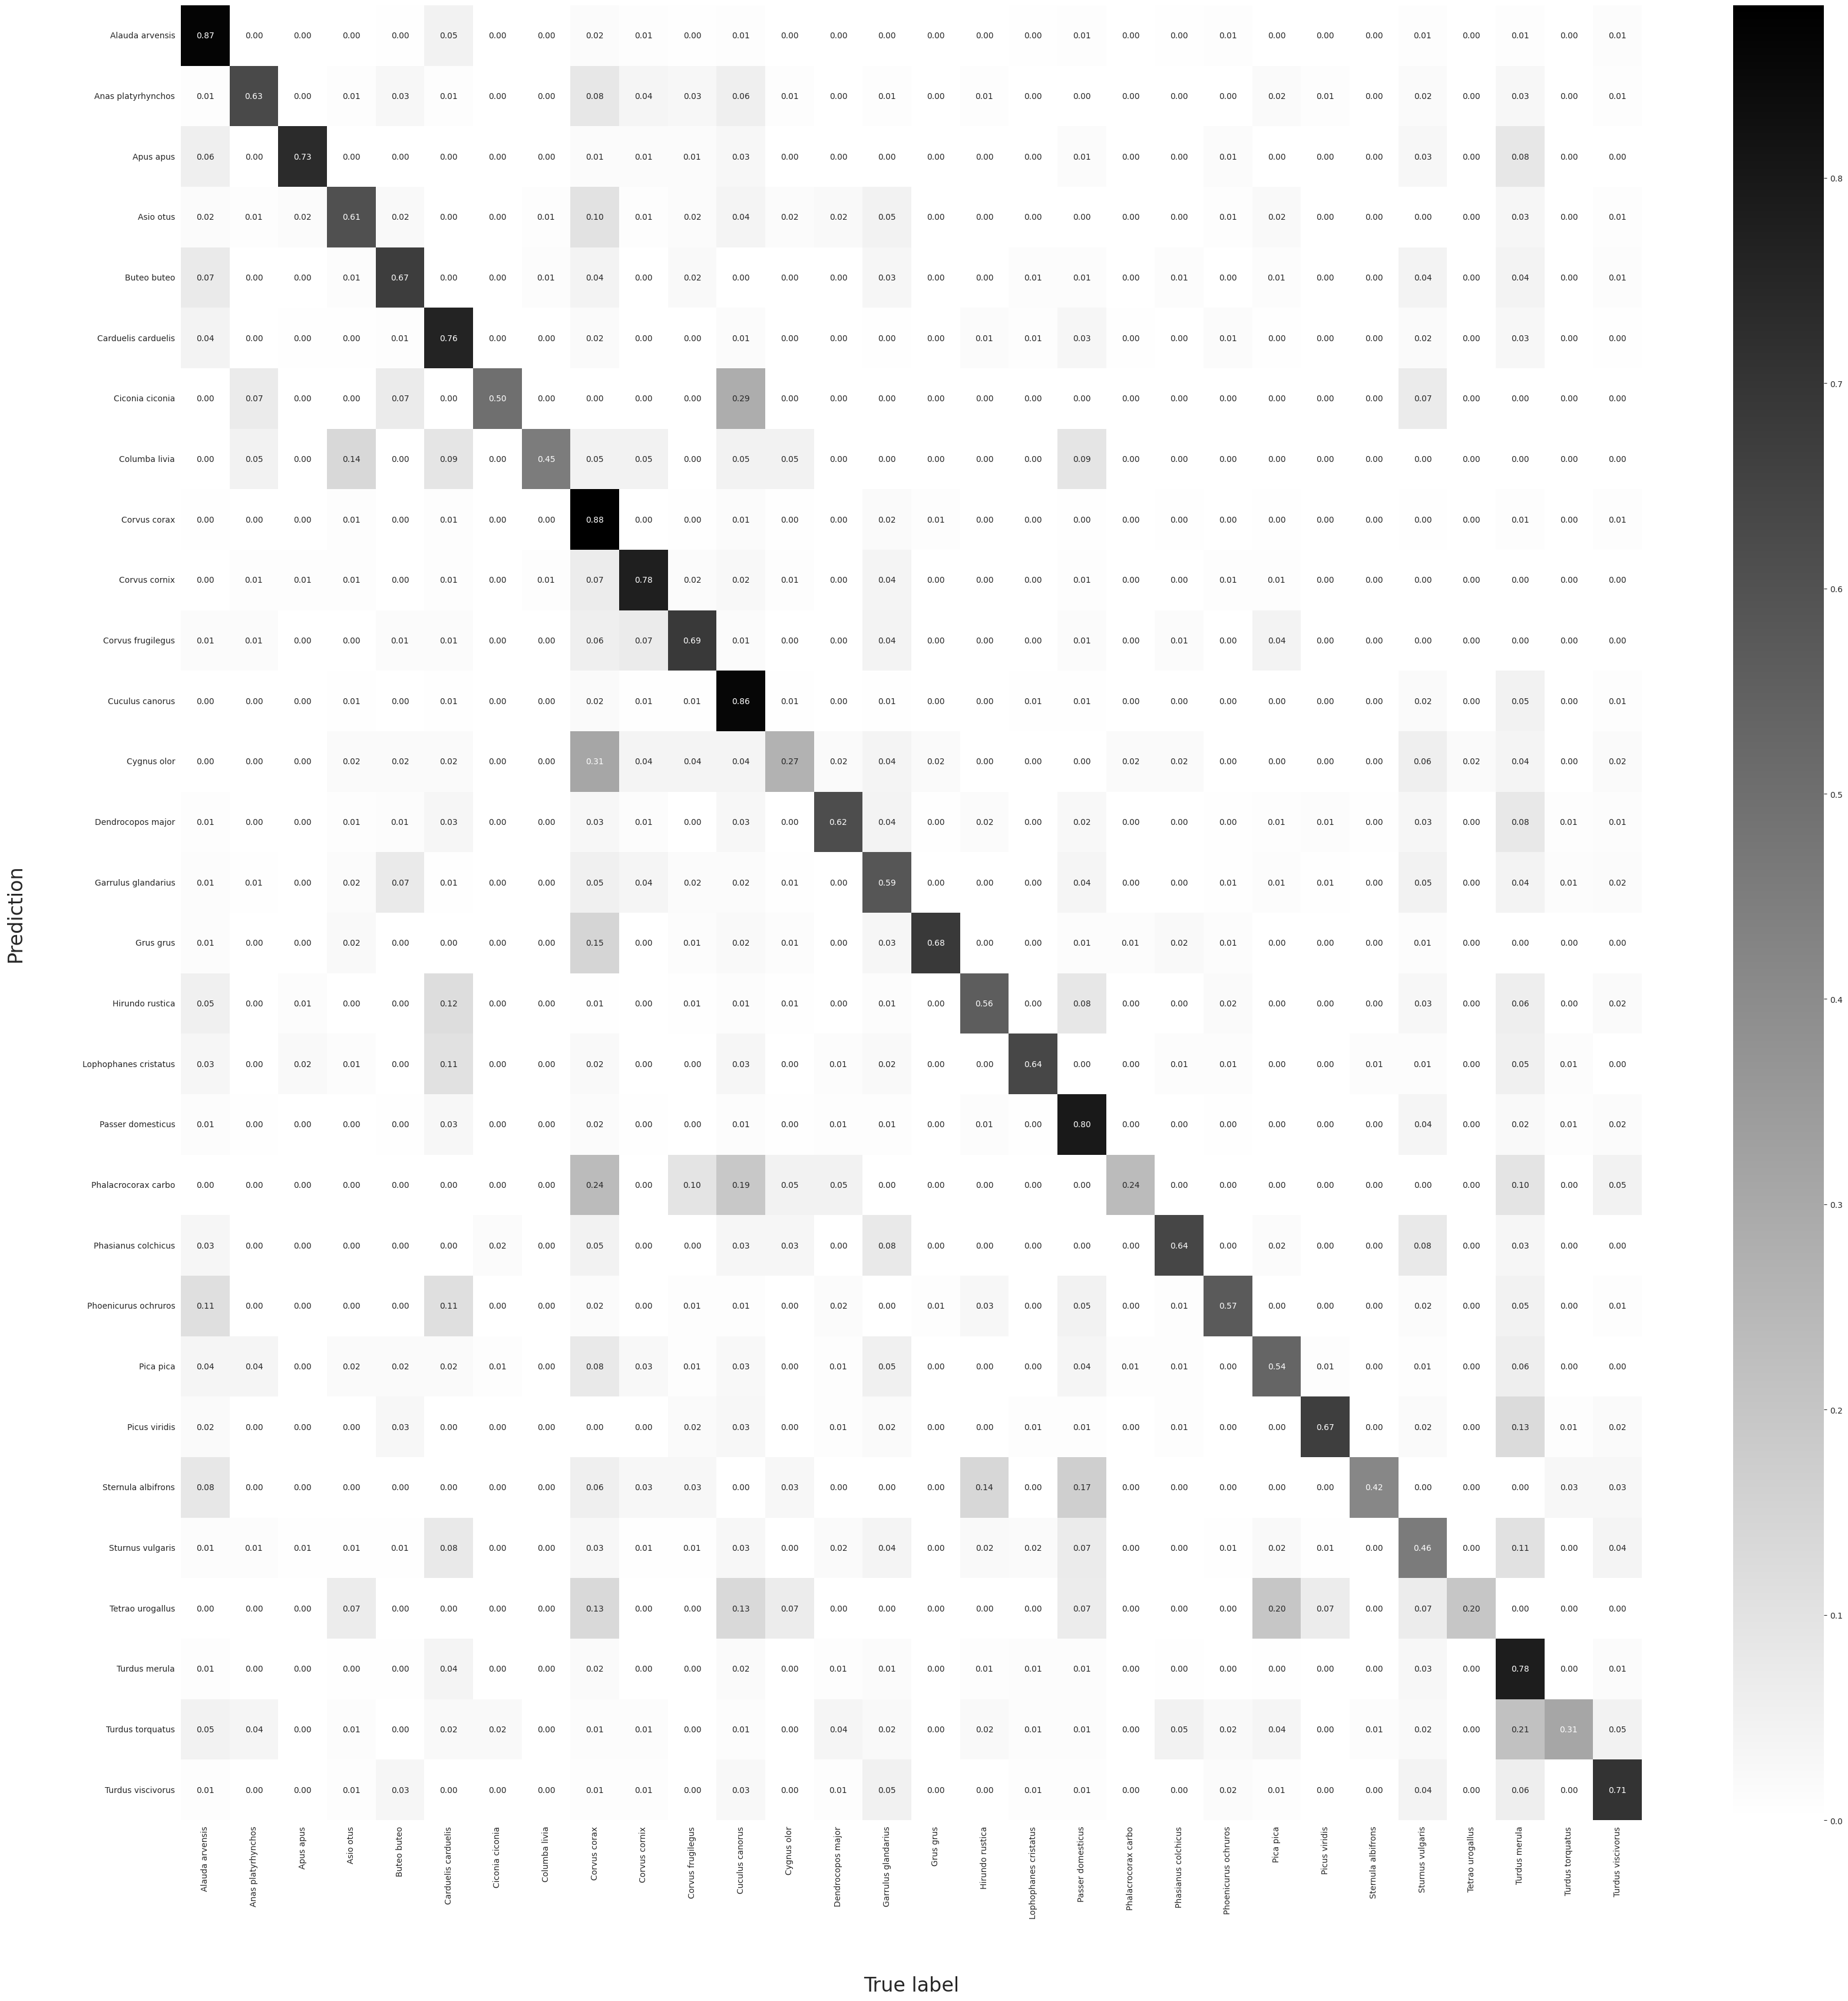

In [29]:
cm = c_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm)
df_cm.columns = train_ds.get_mapping().values()
df_cm.index = train_ds.get_mapping().values()
plt.figure(figsize = (40,40))
s = sns.heatmap(df_cm, annot=True, cmap = 'binary', fmt='.2f')
s.set_xlabel('True label', fontsize=24, labelpad=70)
s.set_ylabel('Prediction', fontsize=24, labelpad=70)
# s.set_title("Confusion matrix of predictions")

## Most common mistakes

In [49]:
import numpy as np


map = train_ds.get_mapping()
def top_n_argmax_2d(array_2d, N):
    np.fill_diagonal(array_2d, 0)
    flat_indices = np.argpartition(array_2d.flatten(), -N)[-N:]
    indices_2d = np.unravel_index(flat_indices, array_2d.shape)
    return list(zip(indices_2d[0], indices_2d[1]))

N = 25 
top_indices = top_n_argmax_2d(cm, N)

# Print the indices of the top N elements
df = pd.DataFrame(columns=["Predicted", "True Label", "Frequency"])
for i, index in enumerate(top_indices):
    df.loc[len(df)] = [map[index[0]], map[index[1]], cm[index]]
df.sort_values(by = "Frequency", ascending=False)

,Predicted,True Label,Frequency
7,Cygnus olor,Corvus corax,0.307692
8,Ciconia ciconia,Cuculus canorus,0.285714
17,Phalacrocorax carbo,Corvus corax,0.238095
9,Turdus torquatus,Turdus merula,0.214286
16,Tetrao urogallus,Pica pica,0.200000
24,Phalacrocorax carbo,Cuculus canorus,0.190476
3,Sternula albifrons,Passer domesticus,0.166667
12,Grus grus,Corvus corax,0.147368
4,Sternula albifrons,Hirundo rustica,0.138889
15,Columba livia,Asio otus,0.136364


## Training

[Text(0.5, 0, 'Step (batch size = 32)'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Train loss')]

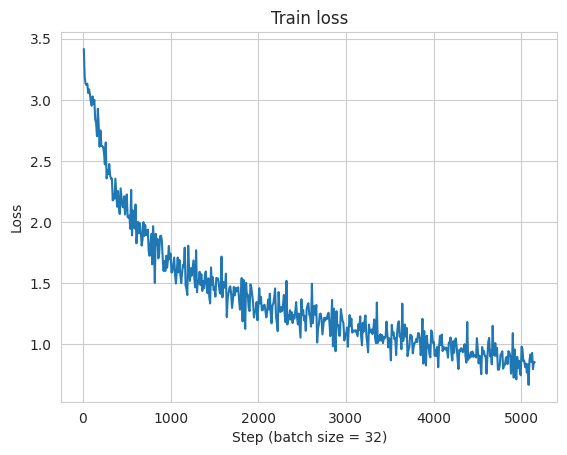

In [24]:
import seaborn as sns
train_loss_df = pd.read_csv('saved_models/cnn_20231121_011424.csv')
ax = sns.lineplot(data=train_loss_df, x="Step", y="Value")
ax.set(xlabel='Step (batch size = 32)', ylabel='Loss', title = 'Train loss')

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Score'),
 Text(0.5, 1.0, 'F1-score (macro)')]

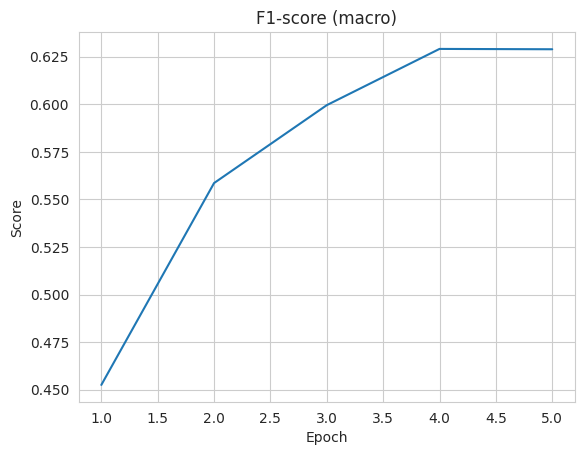

In [27]:
maf1 = pd.read_csv('saved_models/cnn_20231121_011424_Macro_averaged_f1_score_Validation.csv')
ax = sns.lineplot(data=maf1, x="Step", y="Value")
ax.set(xlabel='Epoch', ylabel='Score', title = "F1-score (macro)")

/tmp/ipykernel_10722/1171937945.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(x="Step", y="Value", hue="split", ci="sd", data=combined_df)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Loss')]

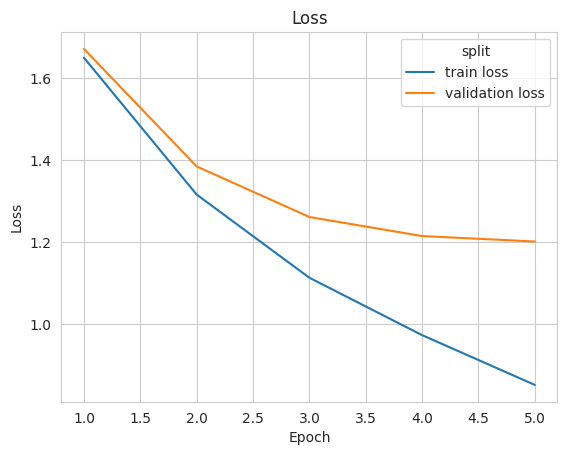

In [51]:
loss_training_df = pd.read_csv('saved_models/cnn_20231121_011424_Training vs. Validation Loss_Training.csv')
loss_validation_df = pd.read_csv('saved_models/cnn_20231121_011424_Training vs. Validation Loss_Validation.csv')
loss_training_df['split'] = 'train loss'
loss_validation_df['split'] = 'validation loss'
loss_training_df = loss_training_df[['Step', 'Value', 'split']]
loss_validation_df = loss_validation_df[['Step', 'Value', 'split']]
combined_df = pd.concat([loss_training_df, loss_validation_df])
ax = sns.lineplot(x="Step", y="Value", hue="split", ci="sd", data=combined_df)
ax.set(xlabel='Epoch', ylabel='Loss', title = "Loss")
